# FSI of a zero-mass 1d plate swimming in quiescent viscous flow

In [1]:
using Revise
using BSON: @save, @load

using Pkg
Pkg.activate("..")
using FSI

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
filename = "2dSwim_zeromass_plate";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [4]:
# problem dimension
ndim = 2
# numerical params
tf = 4
dt = 1e-3
scheme = "Liska"
st = 5
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0., 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 3
config_body = ConfigBody(nbody, 4, [0. 0.; 1. 0.; 1. 1.0; 0. 1.0], 0.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)
gap = 0.1;

#### set the first passive planar joint with no stiff and damp

In [5]:
dof₁ = Vector{Dof}(undef,3)
[dof₁[i] = Dof(i+2, "passive", 0., 0., Motions()) for i = 1:3]
config_joints[1] = ConfigJoint(njoint, "planar",
    [0.,0.,0.,0.6,2.0,0.], zeros(Float64,6), 0, dof₁, [0.0,0.0,0.0]);

#### set the second active joint with oscillatory motion

In [6]:
motion₂ = Motions("oscillatory", [-1.0, 1.0/(2*π), -π/2])
dof₂ = Dof(3, "active", 0., 0., motion₂)
config_joints[2] = ConfigJoint(njoint, "revolute",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   1, [dof₂], [0.]);

#### set the third active joint with oscillatory motion

In [7]:
motion₃ = Motions("oscillatory", [-1.0, 1.0/(2*π), 0.0])
dof₃ = Dof(3, "active", 0., 0., motion₃)
config_joints[3] = ConfigJoint(njoint, "revolute",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   2, [dof₃], [0.]);

#### Build joint-body chain

In [8]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys);

#### Initialize rigid body system state to complete body-joint information

In [9]:
bd, soln₀ = InitSystem!(bd;influid=true);

#### Initialize u and λ container

In [10]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [11]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

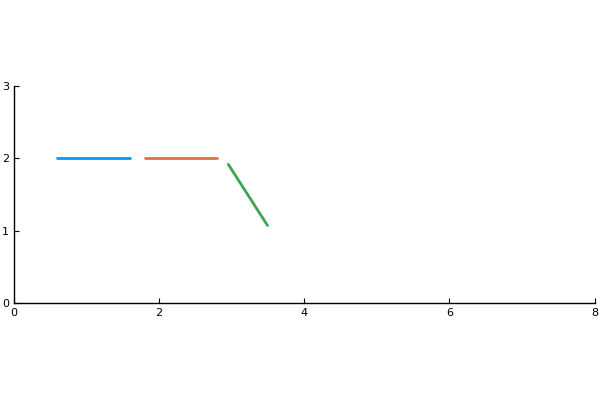

In [12]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,8), ylims=(0,3), ratio=1, legend=false)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [13]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [14]:
nx = 402; ny = 152;
Ly = 3;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:8.01, -0.01:0.02:3.0100000000000002)

#### Set up fluid initial conditions

In [15]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [16]:
plane = [1,2];

#### Genrate body grid points and get linear velocity on them

In [17]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx, fine=3.0))
bgs = CutOut2d(bd,bgs);

#### Get body points initial coordinates for fluids

In [18]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [19]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [20]:
tf = 2500Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

153

## <span style="color:blue"> Create ifherk object </span>

In [21]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=TimeMarching.RK31, bodydim=1)

 22.462917 seconds (67.68 M allocations: 5.227 GiB, 5.18% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [22]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [23]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
end

 17.663219 seconds (44.29 M allocations: 4.249 GiB, 2.95% gc time)
next time unit is 0.01
 14.843455 seconds (36.26 M allocations: 3.956 GiB, 3.38% gc time)
next time unit is 0.02
 15.293815 seconds (36.26 M allocations: 3.956 GiB, 2.55% gc time)
next time unit is 0.03
 15.144943 seconds (36.26 M allocations: 3.956 GiB, 2.59% gc time)
next time unit is 0.04
 15.529590 seconds (36.26 M allocations: 3.956 GiB, 3.09% gc time)
next time unit is 0.05
 15.249655 seconds (36.26 M allocations: 3.956 GiB, 2.50% gc time)
next time unit is 0.06
 15.368823 seconds (36.26 M allocations: 3.956 GiB, 3.21% gc time)
next time unit is 0.07
 16.041712 seconds (36.26 M allocations: 3.956 GiB, 2.45% gc time)
next time unit is 0.08
 15.592522 seconds (36.26 M allocations: 3.956 GiB, 2.49% gc time)
next time unit is 0.09
 15.591643 seconds (36.26 M allocations: 3.956 GiB, 3.13% gc time)
next time unit is 0.1
 14.686456 seconds (36.26 M allocations: 3.956 GiB, 2.58% gc time)
next time unit is 0.11
 14.703704 

 14.229070 seconds (36.26 M allocations: 3.956 GiB, 3.20% gc time)
next time unit is 0.93
 14.113447 seconds (36.26 M allocations: 3.956 GiB, 2.66% gc time)
next time unit is 0.94
 14.290521 seconds (36.26 M allocations: 3.956 GiB, 3.24% gc time)
next time unit is 0.95
 14.086170 seconds (36.26 M allocations: 3.956 GiB, 2.63% gc time)
next time unit is 0.96
 14.242739 seconds (36.26 M allocations: 3.956 GiB, 2.66% gc time)
next time unit is 0.97
 14.274669 seconds (36.26 M allocations: 3.956 GiB, 3.24% gc time)
next time unit is 0.98
 14.064408 seconds (36.26 M allocations: 3.956 GiB, 2.62% gc time)
next time unit is 0.99
 14.196755 seconds (36.26 M allocations: 3.956 GiB, 2.65% gc time)
next time unit is 1.0
 14.190414 seconds (36.26 M allocations: 3.956 GiB, 3.28% gc time)
next time unit is 1.01
 14.118847 seconds (36.26 M allocations: 3.956 GiB, 2.62% gc time)
next time unit is 1.02
 14.248793 seconds (36.26 M allocations: 3.956 GiB, 3.27% gc time)
next time unit is 1.03
 14.089370 

 16.253263 seconds (36.26 M allocations: 3.956 GiB, 2.56% gc time)
next time unit is 1.85
 15.355260 seconds (36.26 M allocations: 3.956 GiB, 3.29% gc time)
next time unit is 1.86
 16.478595 seconds (36.26 M allocations: 3.956 GiB, 2.44% gc time)
next time unit is 1.87
 17.307133 seconds (36.26 M allocations: 3.956 GiB, 2.41% gc time)
next time unit is 1.88
 17.683525 seconds (36.26 M allocations: 3.956 GiB, 2.90% gc time)
next time unit is 1.89
 18.238083 seconds (36.26 M allocations: 3.956 GiB, 2.27% gc time)
next time unit is 1.9
 17.911477 seconds (36.26 M allocations: 3.956 GiB, 2.98% gc time)
next time unit is 1.91
 17.757235 seconds (36.26 M allocations: 3.956 GiB, 2.29% gc time)
next time unit is 1.92
 17.872274 seconds (36.26 M allocations: 3.956 GiB, 2.30% gc time)
next time unit is 1.93
 17.688998 seconds (36.26 M allocations: 3.956 GiB, 2.98% gc time)
next time unit is 1.94
 17.693016 seconds (36.26 M allocations: 3.956 GiB, 2.27% gc time)
next time unit is 1.95
 17.781029 

 20.065131 seconds (36.26 M allocations: 3.956 GiB, 2.94% gc time)
next time unit is 2.77
 17.940786 seconds (36.26 M allocations: 3.956 GiB, 2.45% gc time)
next time unit is 2.78
 18.044472 seconds (36.26 M allocations: 3.956 GiB, 3.15% gc time)
next time unit is 2.79
 17.845902 seconds (36.26 M allocations: 3.956 GiB, 2.49% gc time)
next time unit is 2.8
 18.151709 seconds (36.26 M allocations: 3.956 GiB, 2.46% gc time)
next time unit is 2.81
 17.873935 seconds (36.26 M allocations: 3.956 GiB, 3.06% gc time)
next time unit is 2.82
 16.775018 seconds (36.26 M allocations: 3.956 GiB, 2.46% gc time)
next time unit is 2.83
 17.571579 seconds (36.26 M allocations: 3.956 GiB, 2.45% gc time)
next time unit is 2.84
 17.347504 seconds (36.26 M allocations: 3.956 GiB, 3.28% gc time)
next time unit is 2.85
 15.909553 seconds (36.26 M allocations: 3.956 GiB, 2.52% gc time)
next time unit is 2.86
 16.881132 seconds (36.26 M allocations: 3.956 GiB, 3.21% gc time)
next time unit is 2.87
 15.957728 

 18.481891 seconds (36.26 M allocations: 3.956 GiB, 2.38% gc time)
next time unit is 3.69
 18.229187 seconds (36.26 M allocations: 3.956 GiB, 3.06% gc time)
next time unit is 3.7
 16.960518 seconds (36.26 M allocations: 3.956 GiB, 2.52% gc time)
next time unit is 3.71
 18.275010 seconds (36.26 M allocations: 3.956 GiB, 2.48% gc time)
next time unit is 3.72
 18.632233 seconds (36.26 M allocations: 3.956 GiB, 3.04% gc time)
next time unit is 3.73
 18.498669 seconds (36.26 M allocations: 3.956 GiB, 2.45% gc time)
next time unit is 3.74
 19.287534 seconds (36.26 M allocations: 3.956 GiB, 2.99% gc time)
next time unit is 3.75
 18.015519 seconds (36.26 M allocations: 3.956 GiB, 2.47% gc time)
next time unit is 3.76
 17.995792 seconds (36.26 M allocations: 3.956 GiB, 2.43% gc time)
next time unit is 3.77
 18.249646 seconds (36.26 M allocations: 3.956 GiB, 3.11% gc time)
next time unit is 3.78
 18.100791 seconds (36.26 M allocations: 3.956 GiB, 2.48% gc time)
next time unit is 3.79
 18.133469 

 19.023098 seconds (36.26 M allocations: 3.956 GiB, 3.14% gc time)
next time unit is 4.61
 18.899014 seconds (36.26 M allocations: 3.956 GiB, 2.36% gc time)
next time unit is 4.62
 18.917700 seconds (36.26 M allocations: 3.956 GiB, 3.14% gc time)
next time unit is 4.63
 18.891559 seconds (36.26 M allocations: 3.956 GiB, 2.43% gc time)
next time unit is 4.64
 19.624427 seconds (36.26 M allocations: 3.956 GiB, 2.37% gc time)
next time unit is 4.65
 18.973515 seconds (36.26 M allocations: 3.956 GiB, 3.12% gc time)
next time unit is 4.66
 18.412875 seconds (36.26 M allocations: 3.956 GiB, 2.44% gc time)
next time unit is 4.67
 18.768138 seconds (36.26 M allocations: 3.956 GiB, 2.45% gc time)
next time unit is 4.68
 18.486552 seconds (36.26 M allocations: 3.956 GiB, 3.14% gc time)
next time unit is 4.69
 19.294195 seconds (36.26 M allocations: 3.956 GiB, 2.38% gc time)
next time unit is 4.7
 19.090801 seconds (36.26 M allocations: 3.956 GiB, 3.08% gc time)
next time unit is 4.71
 19.057317 

 19.121652 seconds (36.26 M allocations: 3.956 GiB, 2.42% gc time)
next time unit is 5.53
 19.256634 seconds (36.26 M allocations: 3.956 GiB, 3.16% gc time)
next time unit is 5.54
 19.087921 seconds (36.26 M allocations: 3.956 GiB, 2.43% gc time)
next time unit is 5.55
 19.361926 seconds (36.26 M allocations: 3.956 GiB, 2.45% gc time)
next time unit is 5.56
 19.194400 seconds (36.26 M allocations: 3.956 GiB, 3.07% gc time)
next time unit is 5.57
 18.703341 seconds (36.26 M allocations: 3.956 GiB, 2.36% gc time)
next time unit is 5.58
 18.999952 seconds (36.26 M allocations: 3.956 GiB, 3.01% gc time)
next time unit is 5.59
 18.975754 seconds (36.26 M allocations: 3.956 GiB, 2.44% gc time)
next time unit is 5.6
 18.981284 seconds (36.26 M allocations: 3.956 GiB, 2.36% gc time)
next time unit is 5.61
 18.992814 seconds (36.26 M allocations: 3.956 GiB, 3.10% gc time)
next time unit is 5.62
 18.513977 seconds (36.26 M allocations: 3.956 GiB, 2.41% gc time)
next time unit is 5.63
 19.275468 

 18.680833 seconds (36.26 M allocations: 3.956 GiB, 3.11% gc time)
next time unit is 6.45
 18.148551 seconds (36.26 M allocations: 3.956 GiB, 2.44% gc time)
next time unit is 6.46
 18.560881 seconds (36.26 M allocations: 3.956 GiB, 3.16% gc time)
next time unit is 6.47
 18.197488 seconds (36.26 M allocations: 3.956 GiB, 2.40% gc time)
next time unit is 6.48
 18.572037 seconds (36.26 M allocations: 3.956 GiB, 2.40% gc time)
next time unit is 6.49
 18.634159 seconds (36.26 M allocations: 3.956 GiB, 3.14% gc time)
next time unit is 6.5
 18.716685 seconds (36.26 M allocations: 3.956 GiB, 2.48% gc time)
next time unit is 6.51
 18.654717 seconds (36.26 M allocations: 3.956 GiB, 2.54% gc time)
next time unit is 6.52
 18.452466 seconds (36.26 M allocations: 3.956 GiB, 3.18% gc time)
next time unit is 6.53
 18.292230 seconds (36.26 M allocations: 3.956 GiB, 2.48% gc time)
next time unit is 6.54
 18.440894 seconds (36.26 M allocations: 3.956 GiB, 3.10% gc time)
next time unit is 6.55
 18.063140 

 18.325511 seconds (36.26 M allocations: 3.956 GiB, 2.51% gc time)
next time unit is 7.37
 18.249474 seconds (36.26 M allocations: 3.956 GiB, 3.22% gc time)
next time unit is 7.38
 18.620507 seconds (36.26 M allocations: 3.956 GiB, 2.45% gc time)
next time unit is 7.39
 18.639251 seconds (36.26 M allocations: 3.956 GiB, 2.48% gc time)
next time unit is 7.4
 18.398304 seconds (36.26 M allocations: 3.956 GiB, 3.11% gc time)
next time unit is 7.41
 18.347516 seconds (36.26 M allocations: 3.956 GiB, 2.57% gc time)
next time unit is 7.42
 18.942204 seconds (36.26 M allocations: 3.956 GiB, 3.18% gc time)
next time unit is 7.43
 18.646528 seconds (36.26 M allocations: 3.956 GiB, 2.48% gc time)
next time unit is 7.44
 18.667615 seconds (36.26 M allocations: 3.956 GiB, 2.52% gc time)
next time unit is 7.45
 18.690012 seconds (36.26 M allocations: 3.956 GiB, 3.13% gc time)
next time unit is 7.46
 18.954532 seconds (36.26 M allocations: 3.956 GiB, 2.39% gc time)
next time unit is 7.47
 18.747820 

 18.464239 seconds (36.26 M allocations: 3.956 GiB, 3.15% gc time)
next time unit is 8.29
 18.916197 seconds (36.26 M allocations: 3.956 GiB, 2.43% gc time)
next time unit is 8.3
 19.123110 seconds (36.26 M allocations: 3.956 GiB, 3.16% gc time)
next time unit is 8.31
 18.614504 seconds (36.26 M allocations: 3.956 GiB, 2.56% gc time)
next time unit is 8.32
 18.449744 seconds (36.26 M allocations: 3.956 GiB, 2.52% gc time)
next time unit is 8.33
 18.164147 seconds (36.26 M allocations: 3.956 GiB, 3.13% gc time)
next time unit is 8.34
 18.926729 seconds (36.26 M allocations: 3.956 GiB, 2.39% gc time)
next time unit is 8.35
 19.079370 seconds (36.26 M allocations: 3.956 GiB, 2.45% gc time)
next time unit is 8.36
 18.453662 seconds (36.26 M allocations: 3.956 GiB, 3.09% gc time)
next time unit is 8.37
 18.821197 seconds (36.26 M allocations: 3.956 GiB, 2.47% gc time)
next time unit is 8.38
 19.388004 seconds (36.26 M allocations: 3.956 GiB, 2.99% gc time)
next time unit is 8.39
 18.496513 

 18.311160 seconds (36.26 M allocations: 3.956 GiB, 2.56% gc time)
next time unit is 9.21
 18.032384 seconds (36.26 M allocations: 3.956 GiB, 3.25% gc time)
next time unit is 9.22
 17.923427 seconds (36.26 M allocations: 3.956 GiB, 2.48% gc time)
next time unit is 9.23
 18.195890 seconds (36.26 M allocations: 3.956 GiB, 2.47% gc time)
next time unit is 9.24
 19.186105 seconds (36.26 M allocations: 3.956 GiB, 3.08% gc time)
next time unit is 9.25
 18.428585 seconds (36.26 M allocations: 3.956 GiB, 2.58% gc time)
next time unit is 9.26
 18.361022 seconds (36.26 M allocations: 3.956 GiB, 3.21% gc time)
next time unit is 9.27
 18.459715 seconds (36.26 M allocations: 3.956 GiB, 2.47% gc time)
next time unit is 9.28
 18.078912 seconds (36.26 M allocations: 3.956 GiB, 2.52% gc time)
next time unit is 9.29
 18.587296 seconds (36.26 M allocations: 3.956 GiB, 3.10% gc time)
next time unit is 9.3
 18.627563 seconds (36.26 M allocations: 3.956 GiB, 2.58% gc time)
next time unit is 9.31
 18.501036 

 14.349098 seconds (36.26 M allocations: 3.956 GiB, 2.82% gc time)
next time unit is 10.12
 14.293584 seconds (36.26 M allocations: 3.956 GiB, 3.48% gc time)
next time unit is 10.13
 14.213053 seconds (36.26 M allocations: 3.956 GiB, 2.75% gc time)
next time unit is 10.14
 14.337230 seconds (36.26 M allocations: 3.956 GiB, 3.41% gc time)
next time unit is 10.15
 14.224154 seconds (36.26 M allocations: 3.956 GiB, 2.76% gc time)
next time unit is 10.16
 14.144024 seconds (36.26 M allocations: 3.956 GiB, 2.76% gc time)
next time unit is 10.17
 14.343461 seconds (36.26 M allocations: 3.956 GiB, 3.39% gc time)
next time unit is 10.18
 14.268777 seconds (36.26 M allocations: 3.956 GiB, 2.74% gc time)
next time unit is 10.19
 14.301634 seconds (36.26 M allocations: 3.956 GiB, 2.75% gc time)
next time unit is 10.2
 15.868222 seconds (36.26 M allocations: 3.956 GiB, 3.17% gc time)
next time unit is 10.21
 14.215978 seconds (36.26 M allocations: 3.956 GiB, 2.76% gc time)
next time unit is 10.22


 14.315442 seconds (36.26 M allocations: 3.956 GiB, 3.46% gc time)
next time unit is 11.03
 14.354834 seconds (36.26 M allocations: 3.956 GiB, 2.72% gc time)
next time unit is 11.04
 14.112271 seconds (36.26 M allocations: 3.956 GiB, 2.79% gc time)
next time unit is 11.05
 14.274670 seconds (36.26 M allocations: 3.956 GiB, 3.51% gc time)
next time unit is 11.06
 14.186477 seconds (36.26 M allocations: 3.956 GiB, 2.75% gc time)
next time unit is 11.07
 14.280646 seconds (36.26 M allocations: 3.956 GiB, 2.83% gc time)
next time unit is 11.08
 15.317250 seconds (36.26 M allocations: 3.956 GiB, 3.39% gc time)
next time unit is 11.09
 14.360013 seconds (36.26 M allocations: 3.956 GiB, 2.73% gc time)
next time unit is 11.1
 14.395388 seconds (36.26 M allocations: 3.956 GiB, 3.45% gc time)
next time unit is 11.11
 14.276672 seconds (36.26 M allocations: 3.956 GiB, 2.75% gc time)
next time unit is 11.12
 14.552464 seconds (36.26 M allocations: 3.956 GiB, 2.70% gc time)
next time unit is 11.13


 14.186068 seconds (36.26 M allocations: 3.956 GiB, 3.58% gc time)
next time unit is 11.94
 14.080467 seconds (36.26 M allocations: 3.956 GiB, 2.81% gc time)
next time unit is 11.95
 14.167289 seconds (36.26 M allocations: 3.956 GiB, 2.85% gc time)
next time unit is 11.96
 14.219898 seconds (36.26 M allocations: 3.956 GiB, 3.50% gc time)
next time unit is 11.97
 14.059060 seconds (36.26 M allocations: 3.956 GiB, 2.80% gc time)
next time unit is 11.98
 14.194835 seconds (36.26 M allocations: 3.956 GiB, 3.61% gc time)
next time unit is 11.99
 14.124501 seconds (36.26 M allocations: 3.956 GiB, 2.77% gc time)
next time unit is 12.0
 14.094762 seconds (36.26 M allocations: 3.956 GiB, 2.87% gc time)
next time unit is 12.01
 14.245287 seconds (36.26 M allocations: 3.956 GiB, 3.55% gc time)
next time unit is 12.02
 14.104154 seconds (36.26 M allocations: 3.956 GiB, 2.78% gc time)
next time unit is 12.03
 14.120057 seconds (36.26 M allocations: 3.956 GiB, 2.83% gc time)
next time unit is 12.04


 15.674029 seconds (36.26 M allocations: 3.956 GiB, 3.42% gc time)
next time unit is 12.85
 15.554816 seconds (36.26 M allocations: 3.956 GiB, 2.65% gc time)
next time unit is 12.86
 15.917975 seconds (36.26 M allocations: 3.956 GiB, 3.37% gc time)
next time unit is 12.87
 15.519693 seconds (36.26 M allocations: 3.956 GiB, 2.68% gc time)
next time unit is 12.88
 16.119867 seconds (36.26 M allocations: 3.956 GiB, 2.65% gc time)
next time unit is 12.89
 15.957254 seconds (36.26 M allocations: 3.956 GiB, 3.30% gc time)
next time unit is 12.9
 16.296940 seconds (36.26 M allocations: 3.956 GiB, 2.62% gc time)
next time unit is 12.91
 15.603883 seconds (36.26 M allocations: 3.956 GiB, 2.69% gc time)
next time unit is 12.92
 15.614551 seconds (36.26 M allocations: 3.956 GiB, 3.28% gc time)
next time unit is 12.93
 14.830138 seconds (36.26 M allocations: 3.956 GiB, 2.72% gc time)
next time unit is 12.94
 15.356376 seconds (36.26 M allocations: 3.956 GiB, 3.45% gc time)
next time unit is 12.95


 14.139376 seconds (36.26 M allocations: 3.956 GiB, 2.82% gc time)
next time unit is 13.76
 14.212672 seconds (36.26 M allocations: 3.956 GiB, 2.79% gc time)
next time unit is 13.77
 14.336064 seconds (36.26 M allocations: 3.956 GiB, 3.47% gc time)
next time unit is 13.78
 14.253460 seconds (36.26 M allocations: 3.956 GiB, 2.80% gc time)
next time unit is 13.79
 14.217472 seconds (36.26 M allocations: 3.956 GiB, 2.80% gc time)
next time unit is 13.8
 14.183618 seconds (36.26 M allocations: 3.956 GiB, 3.52% gc time)
next time unit is 13.81
 14.198626 seconds (36.26 M allocations: 3.956 GiB, 2.79% gc time)
next time unit is 13.82
 14.644475 seconds (36.26 M allocations: 3.956 GiB, 3.49% gc time)
next time unit is 13.83
 14.275434 seconds (36.26 M allocations: 3.956 GiB, 2.80% gc time)
next time unit is 13.84
 14.268383 seconds (36.26 M allocations: 3.956 GiB, 2.83% gc time)
next time unit is 13.85
 14.331267 seconds (36.26 M allocations: 3.956 GiB, 3.45% gc time)
next time unit is 13.86


 14.160239 seconds (36.26 M allocations: 3.956 GiB, 2.80% gc time)
next time unit is 14.67
 14.251454 seconds (36.26 M allocations: 3.956 GiB, 2.82% gc time)
next time unit is 14.68
 14.221569 seconds (36.26 M allocations: 3.956 GiB, 3.49% gc time)
next time unit is 14.69
 14.103464 seconds (36.26 M allocations: 3.956 GiB, 2.80% gc time)
next time unit is 14.7
 14.387671 seconds (36.26 M allocations: 3.956 GiB, 3.55% gc time)
next time unit is 14.71
 14.182764 seconds (36.26 M allocations: 3.956 GiB, 2.81% gc time)
next time unit is 14.72
 14.102824 seconds (36.26 M allocations: 3.956 GiB, 2.82% gc time)
next time unit is 14.73
 14.434969 seconds (36.26 M allocations: 3.956 GiB, 3.49% gc time)
next time unit is 14.74
 14.185383 seconds (36.26 M allocations: 3.956 GiB, 2.82% gc time)
next time unit is 14.75
 14.249885 seconds (36.26 M allocations: 3.956 GiB, 2.79% gc time)
next time unit is 14.76
 14.322940 seconds (36.26 M allocations: 3.956 GiB, 3.60% gc time)
next time unit is 14.77


 14.258325 seconds (36.26 M allocations: 3.956 GiB, 2.84% gc time)
next time unit is 15.58
 14.428347 seconds (36.26 M allocations: 3.956 GiB, 3.56% gc time)
next time unit is 15.59
 14.330478 seconds (36.26 M allocations: 3.956 GiB, 2.79% gc time)
next time unit is 15.6
 14.244490 seconds (36.26 M allocations: 3.956 GiB, 2.82% gc time)
next time unit is 15.61
 14.344111 seconds (36.26 M allocations: 3.956 GiB, 3.53% gc time)
next time unit is 15.62
 14.262137 seconds (36.26 M allocations: 3.956 GiB, 2.79% gc time)
next time unit is 15.63
 14.383695 seconds (36.26 M allocations: 3.956 GiB, 2.86% gc time)
next time unit is 15.64
 14.312435 seconds (36.26 M allocations: 3.956 GiB, 3.52% gc time)
next time unit is 15.65
 14.345697 seconds (36.26 M allocations: 3.956 GiB, 2.80% gc time)
next time unit is 15.66
 14.453833 seconds (36.26 M allocations: 3.956 GiB, 3.54% gc time)
next time unit is 15.67
 14.227665 seconds (36.26 M allocations: 3.956 GiB, 2.83% gc time)
next time unit is 15.68


 14.212046 seconds (36.26 M allocations: 3.956 GiB, 2.84% gc time)
next time unit is 16.49
 14.453907 seconds (36.26 M allocations: 3.956 GiB, 3.58% gc time)
next time unit is 16.5
 14.258151 seconds (36.26 M allocations: 3.956 GiB, 2.84% gc time)
next time unit is 16.51
 14.241131 seconds (36.26 M allocations: 3.956 GiB, 2.86% gc time)
next time unit is 16.52
 14.386449 seconds (36.26 M allocations: 3.956 GiB, 3.68% gc time)
next time unit is 16.53
 14.232618 seconds (36.26 M allocations: 3.956 GiB, 2.82% gc time)
next time unit is 16.54
 14.551240 seconds (36.26 M allocations: 3.956 GiB, 3.54% gc time)
next time unit is 16.55
 14.203129 seconds (36.26 M allocations: 3.956 GiB, 2.80% gc time)
next time unit is 16.56
 14.235983 seconds (36.26 M allocations: 3.956 GiB, 2.84% gc time)
next time unit is 16.57
 14.356785 seconds (36.26 M allocations: 3.956 GiB, 3.57% gc time)
next time unit is 16.58
 14.193073 seconds (36.26 M allocations: 3.956 GiB, 2.81% gc time)
next time unit is 16.59


 14.262787 seconds (36.26 M allocations: 3.956 GiB, 2.84% gc time)
next time unit is 17.4
 14.382129 seconds (36.26 M allocations: 3.956 GiB, 3.57% gc time)
next time unit is 17.41
 14.366880 seconds (36.26 M allocations: 3.956 GiB, 2.82% gc time)
next time unit is 17.42
 14.314612 seconds (36.26 M allocations: 3.956 GiB, 3.61% gc time)
next time unit is 17.43
 14.172337 seconds (36.26 M allocations: 3.956 GiB, 2.86% gc time)
next time unit is 17.44
 14.258265 seconds (36.26 M allocations: 3.956 GiB, 2.86% gc time)
next time unit is 17.45
 14.342771 seconds (36.26 M allocations: 3.956 GiB, 3.56% gc time)
next time unit is 17.46
 14.257124 seconds (36.26 M allocations: 3.956 GiB, 2.84% gc time)
next time unit is 17.47
 14.528394 seconds (36.26 M allocations: 3.956 GiB, 2.86% gc time)
next time unit is 17.48
 14.417391 seconds (36.26 M allocations: 3.956 GiB, 3.56% gc time)
next time unit is 17.49
 14.396240 seconds (36.26 M allocations: 3.956 GiB, 2.82% gc time)
next time unit is 17.5
 

 14.393365 seconds (36.26 M allocations: 3.956 GiB, 3.64% gc time)
next time unit is 18.31
 14.385628 seconds (36.26 M allocations: 3.956 GiB, 2.88% gc time)
next time unit is 18.32
 14.309460 seconds (36.26 M allocations: 3.956 GiB, 2.85% gc time)
next time unit is 18.33
 14.267865 seconds (36.26 M allocations: 3.956 GiB, 3.69% gc time)
next time unit is 18.34
 14.220945 seconds (36.26 M allocations: 3.956 GiB, 2.87% gc time)
next time unit is 18.35
 14.397049 seconds (36.26 M allocations: 3.956 GiB, 2.84% gc time)
next time unit is 18.36
 14.485404 seconds (36.26 M allocations: 3.956 GiB, 3.67% gc time)
next time unit is 18.37
 14.315440 seconds (36.26 M allocations: 3.956 GiB, 2.87% gc time)
next time unit is 18.38
 14.410943 seconds (36.26 M allocations: 3.956 GiB, 3.60% gc time)
next time unit is 18.39
 14.293926 seconds (36.26 M allocations: 3.956 GiB, 2.86% gc time)
next time unit is 18.4
 14.403104 seconds (36.26 M allocations: 3.956 GiB, 2.85% gc time)
next time unit is 18.41


 14.398790 seconds (36.26 M allocations: 3.956 GiB, 3.61% gc time)
next time unit is 19.22
 14.258466 seconds (36.26 M allocations: 3.956 GiB, 2.88% gc time)
next time unit is 19.23
 14.368215 seconds (36.26 M allocations: 3.956 GiB, 2.92% gc time)
next time unit is 19.24
 14.341249 seconds (36.26 M allocations: 3.956 GiB, 3.60% gc time)
next time unit is 19.25
 14.200013 seconds (36.26 M allocations: 3.956 GiB, 2.87% gc time)
next time unit is 19.26
 14.366380 seconds (36.26 M allocations: 3.956 GiB, 3.66% gc time)
next time unit is 19.27
 14.199689 seconds (36.26 M allocations: 3.956 GiB, 2.91% gc time)
next time unit is 19.28
 14.136500 seconds (36.26 M allocations: 3.956 GiB, 2.89% gc time)
next time unit is 19.29
 14.309977 seconds (36.26 M allocations: 3.956 GiB, 3.61% gc time)
next time unit is 19.3
 14.266231 seconds (36.26 M allocations: 3.956 GiB, 2.89% gc time)
next time unit is 19.31
 14.145669 seconds (36.26 M allocations: 3.956 GiB, 2.90% gc time)
next time unit is 19.32


 14.316108 seconds (36.26 M allocations: 3.956 GiB, 3.61% gc time)
next time unit is 20.13
 14.393948 seconds (36.26 M allocations: 3.956 GiB, 2.90% gc time)
next time unit is 20.14
 14.321931 seconds (36.26 M allocations: 3.956 GiB, 3.69% gc time)
next time unit is 20.15
 15.382250 seconds (36.26 M allocations: 3.956 GiB, 2.70% gc time)
next time unit is 20.16
 14.271074 seconds (36.26 M allocations: 3.956 GiB, 2.91% gc time)
next time unit is 20.17
 14.255645 seconds (36.26 M allocations: 3.956 GiB, 3.62% gc time)
next time unit is 20.18
 14.259557 seconds (36.26 M allocations: 3.956 GiB, 2.87% gc time)
next time unit is 20.19
 14.323693 seconds (36.26 M allocations: 3.956 GiB, 2.93% gc time)
next time unit is 20.2
 14.446766 seconds (36.26 M allocations: 3.956 GiB, 3.65% gc time)
next time unit is 20.21
 14.171841 seconds (36.26 M allocations: 3.956 GiB, 2.91% gc time)
next time unit is 20.22
 14.306202 seconds (36.26 M allocations: 3.956 GiB, 3.67% gc time)
next time unit is 20.23


 14.161558 seconds (36.26 M allocations: 3.956 GiB, 2.93% gc time)
next time unit is 21.04
 14.234792 seconds (36.26 M allocations: 3.956 GiB, 2.91% gc time)
next time unit is 21.05
 14.328428 seconds (36.26 M allocations: 3.956 GiB, 3.70% gc time)
next time unit is 21.06
 14.244159 seconds (36.26 M allocations: 3.956 GiB, 2.93% gc time)
next time unit is 21.07
 14.332285 seconds (36.26 M allocations: 3.956 GiB, 2.96% gc time)
next time unit is 21.08
 14.471737 seconds (36.26 M allocations: 3.956 GiB, 3.63% gc time)
next time unit is 21.09
 14.287582 seconds (36.26 M allocations: 3.956 GiB, 2.92% gc time)
next time unit is 21.1
 14.511961 seconds (36.26 M allocations: 3.956 GiB, 3.67% gc time)
next time unit is 21.11
 14.151072 seconds (36.26 M allocations: 3.956 GiB, 2.94% gc time)
next time unit is 21.12
 14.222348 seconds (36.26 M allocations: 3.956 GiB, 2.94% gc time)
next time unit is 21.13
 14.329609 seconds (36.26 M allocations: 3.956 GiB, 3.66% gc time)
next time unit is 21.14


 14.119352 seconds (36.26 M allocations: 3.956 GiB, 2.94% gc time)
next time unit is 21.95
 14.207946 seconds (36.26 M allocations: 3.956 GiB, 2.92% gc time)
next time unit is 21.96
 14.244795 seconds (36.26 M allocations: 3.956 GiB, 3.66% gc time)
next time unit is 21.97
 14.247093 seconds (36.26 M allocations: 3.956 GiB, 2.91% gc time)
next time unit is 21.98
 14.335420 seconds (36.26 M allocations: 3.956 GiB, 3.71% gc time)
next time unit is 21.99
 14.193341 seconds (36.26 M allocations: 3.956 GiB, 2.97% gc time)
next time unit is 22.0
 14.223915 seconds (36.26 M allocations: 3.956 GiB, 2.94% gc time)
next time unit is 22.01
 14.358178 seconds (36.26 M allocations: 3.956 GiB, 3.65% gc time)
next time unit is 22.02
 14.449500 seconds (36.26 M allocations: 3.956 GiB, 2.90% gc time)
next time unit is 22.03
 14.295161 seconds (36.26 M allocations: 3.956 GiB, 2.95% gc time)
next time unit is 22.04
 14.282472 seconds (36.26 M allocations: 3.956 GiB, 3.71% gc time)
next time unit is 22.05


 14.227498 seconds (36.26 M allocations: 3.956 GiB, 2.94% gc time)
next time unit is 22.86
 14.354141 seconds (36.26 M allocations: 3.956 GiB, 3.72% gc time)
next time unit is 22.87
 14.175650 seconds (36.26 M allocations: 3.956 GiB, 2.94% gc time)
next time unit is 22.88
 14.129043 seconds (36.26 M allocations: 3.956 GiB, 2.96% gc time)
next time unit is 22.89
 14.244172 seconds (36.26 M allocations: 3.956 GiB, 3.68% gc time)
next time unit is 22.9
 14.264150 seconds (36.26 M allocations: 3.956 GiB, 2.93% gc time)
next time unit is 22.91
 14.150243 seconds (36.26 M allocations: 3.956 GiB, 2.95% gc time)
next time unit is 22.92
 14.473264 seconds (36.26 M allocations: 3.956 GiB, 3.65% gc time)
next time unit is 22.93
 14.340094 seconds (36.26 M allocations: 3.956 GiB, 2.93% gc time)
next time unit is 22.94
 14.392858 seconds (36.26 M allocations: 3.956 GiB, 3.76% gc time)
next time unit is 22.95
 14.241006 seconds (36.26 M allocations: 3.956 GiB, 2.95% gc time)
next time unit is 22.96


 14.370284 seconds (36.26 M allocations: 3.956 GiB, 3.01% gc time)
next time unit is 23.77
 14.250119 seconds (36.26 M allocations: 3.956 GiB, 3.83% gc time)
next time unit is 23.78
 14.170731 seconds (36.26 M allocations: 3.956 GiB, 2.98% gc time)
next time unit is 23.79
 14.144750 seconds (36.26 M allocations: 3.956 GiB, 3.01% gc time)
next time unit is 23.8
 14.401756 seconds (36.26 M allocations: 3.956 GiB, 3.76% gc time)
next time unit is 23.81
 14.133092 seconds (36.26 M allocations: 3.956 GiB, 2.98% gc time)
next time unit is 23.82
 14.372301 seconds (36.26 M allocations: 3.956 GiB, 3.82% gc time)
next time unit is 23.83
 14.235429 seconds (36.26 M allocations: 3.956 GiB, 2.98% gc time)
next time unit is 23.84
 14.250062 seconds (36.26 M allocations: 3.956 GiB, 2.98% gc time)
next time unit is 23.85
 14.491502 seconds (36.26 M allocations: 3.956 GiB, 3.74% gc time)
next time unit is 23.86
 14.203029 seconds (36.26 M allocations: 3.956 GiB, 2.99% gc time)
next time unit is 23.87


 14.311068 seconds (36.26 M allocations: 3.956 GiB, 3.02% gc time)
next time unit is 24.68
 14.296221 seconds (36.26 M allocations: 3.956 GiB, 3.77% gc time)
next time unit is 24.69
 14.289127 seconds (36.26 M allocations: 3.956 GiB, 2.98% gc time)
next time unit is 24.7
 14.326743 seconds (36.26 M allocations: 3.956 GiB, 3.87% gc time)
next time unit is 24.71
 14.159974 seconds (36.26 M allocations: 3.956 GiB, 3.00% gc time)
next time unit is 24.72
 14.220013 seconds (36.26 M allocations: 3.956 GiB, 3.00% gc time)
next time unit is 24.73
 14.309357 seconds (36.26 M allocations: 3.956 GiB, 3.80% gc time)
next time unit is 24.74
 14.152288 seconds (36.26 M allocations: 3.956 GiB, 2.99% gc time)
next time unit is 24.75
 14.253938 seconds (36.26 M allocations: 3.956 GiB, 3.06% gc time)
next time unit is 24.76
 14.292582 seconds (36.26 M allocations: 3.956 GiB, 3.79% gc time)
next time unit is 24.77
 14.218499 seconds (36.26 M allocations: 3.956 GiB, 3.00% gc time)
next time unit is 24.78


## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [24]:
contour_levels = range(-5*Δx,stop=5*Δx,length=40)
sample_rate = 5
clims = (-5*Δx,5*Δx)
fps = 25;

In [25]:
# contour_levels = range(0.5*minimum(w.data),stop=0.5*maximum(w.data),length=40)
# sample_rate = 5
# clims = (0.5*minimum(w.data),0.5*maximum(w.data))
# fps = 25;

In [26]:
contour_levels

-0.1:0.005128205128205128:0.1

#### Get body verts history

In [27]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

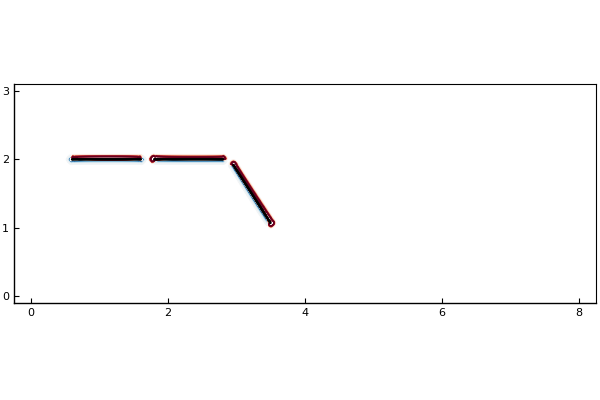

In [28]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p

#### 0.8T

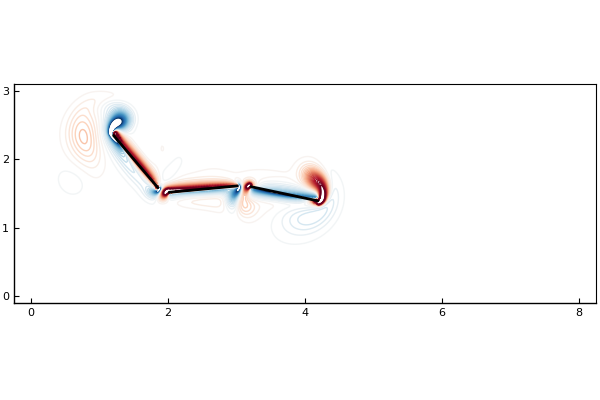

In [29]:
kk = 502
p = plot(xg,yg,whist[kk],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[kk][i,2:3,1], vshist[kk][i,2:3,2],linewidth=2,linecolor="black")
end
p

#### 1.6T

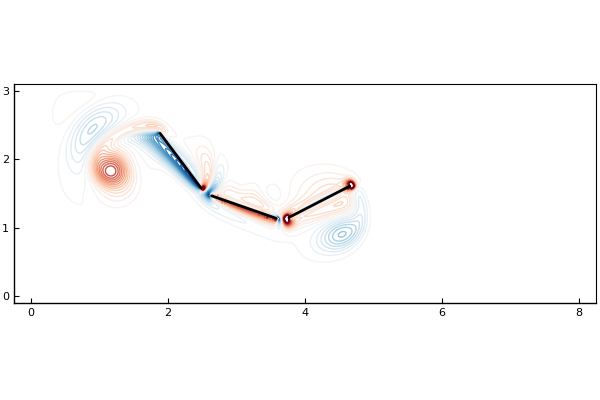

In [30]:
kk = 1005
p = plot(xg,yg,whist[kk],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[kk][i,2:3,1], vshist[kk][i,2:3,2],linewidth=2,linecolor="black")
end
p

#### 2.39T

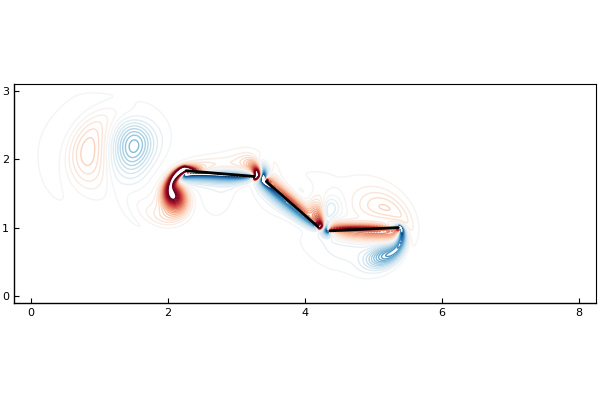

In [31]:
kk = 1501
p = plot(xg,yg,whist[kk],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[kk][i,2:3,1], vshist[kk][i,2:3,2],linewidth=2,linecolor="black")
end
p

#### 3.18T

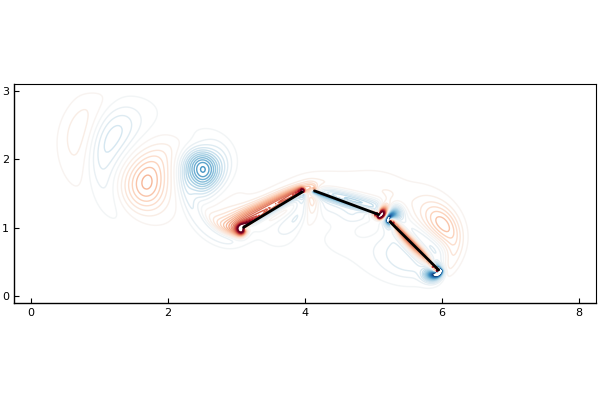

In [32]:
kk = 1998
p = plot(xg,yg,whist[kk],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[kk][i,2:3,1], vshist[kk][i,2:3,2],linewidth=2,linecolor="black")
end
p

#### 3.98T

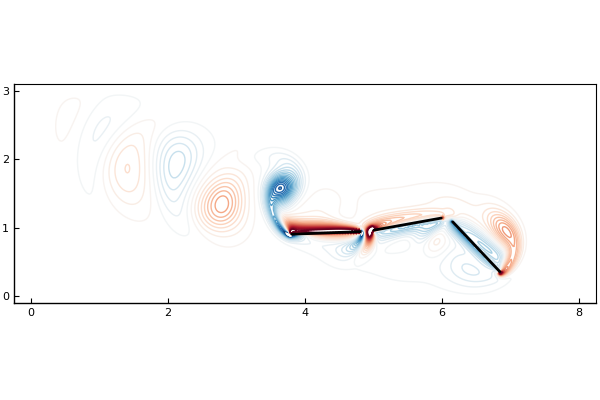

In [33]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

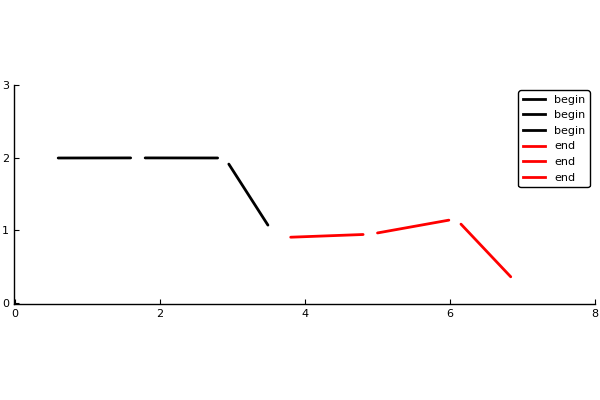

In [34]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1)
pb

#### gif with tail

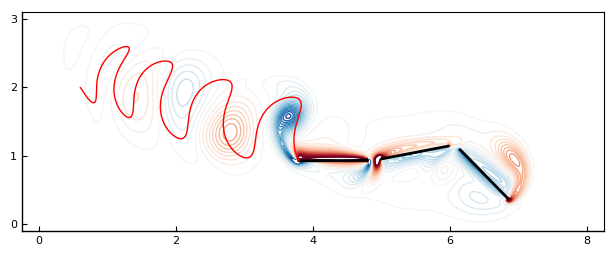

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/2dSwim_zeromass_plate.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/2dSwim_zeromass_plate.gif")

In [35]:
v1_x = []
v1_y = []

anim = @animate for j = 1:sample_rate:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_r,clims=clims)
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
    push!(v1_x,vshist[j][1,2,1])
    push!(v1_y,vshist[j][1,2,2])
    plot!(v1_x,v1_y,linecolor="red")
end

gif(anim, filename*".gif", fps = fps)

#### gif with 2nd body's center

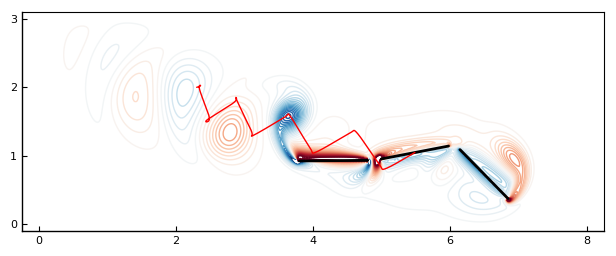

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/2dSwim_zeromass_plate_center.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/2dSwim_zeromass_plate_center.gif")

In [36]:
v1_x = []
v1_y = []

anim = @animate for j = 1:sample_rate:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_r,clims=clims)
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
    push!(v1_x,0.5*(vshist[j][2,2,1]+vshist[j][2,3,1]))
    push!(v1_y,0.5*(vshist[j][2,2,2]+vshist[j][2,3,2]))
    plot!(v1_x,v1_y,linecolor="red")
end

gif(anim, filename*"_center.gif", fps = fps)

#### Lift and drag coefficient

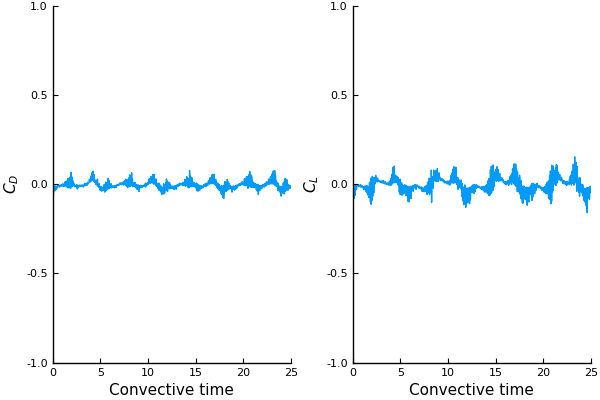

In [37]:
px = plot(thist,2*fx,xlim=(0,25),ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,xlim=(0,25),ylim=(-1,1),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

#### position of the central body

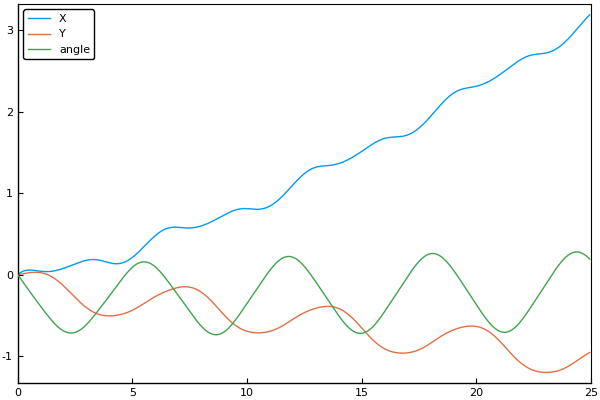

In [38]:
v2_x = []
v2_y = []
α2 = []
t_sampled = []
cnt = 1

for j = 1:sample_rate:length(whist)
    push!(t_sampled,thist[j])
    push!(v2_x,0.5*(vshist[j][2,2,1]+vshist[j][2,3,1])-2.3)
    push!(v2_y,0.5*(vshist[j][2,2,2]+vshist[j][2,3,2])-2)
    push!(α2,atan((v2_y[cnt]+2-vshist[j][2,2,2])/(v2_x[cnt]+2.3-vshist[j][2,2,1])))
    cnt += 1
end

plot(t_sampled,v2_x,label="X", framestyle = :box,xlim=(0,25))
plot!(t_sampled,v2_y,label="Y")
plot!(t_sampled,α2,label="angle")

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .bson file

In [42]:
# @save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [40]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);

In [41]:
t

25.00000000000111